In [28]:
import numpy as np 
import pandas as pd


import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("seaborn-pastel")

%matplotlib inline

import plotly.graph_objects as go
import plotly.express as px


from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler

# Initial Data Analysis

In [29]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
wine_quality = fetch_ucirepo(id=186) 

df = pd.DataFrame(wine_quality.data.original)

#replacing red and white in the target variable 0 and 1
df['color'] = df['color'].map({'red':0, 'white':1})

print(df)

correlation_matrix = df.corr()

# Correlation with 'color' column
correlation_with_color = correlation_matrix['color']

print(correlation_with_color)

avg_quality = df.groupby("color").mean()
avg_quality

      fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0               7.4              0.70         0.00             1.9      0.076   
1               7.8              0.88         0.00             2.6      0.098   
2               7.8              0.76         0.04             2.3      0.092   
3              11.2              0.28         0.56             1.9      0.075   
4               7.4              0.70         0.00             1.9      0.076   
...             ...               ...          ...             ...        ...   
6492            6.2              0.21         0.29             1.6      0.039   
6493            6.6              0.32         0.36             8.0      0.047   
6494            6.5              0.24         0.19             1.2      0.041   
6495            5.5              0.29         0.30             1.1      0.022   
6496            6.0              0.21         0.38             0.8      0.020   

      free_sulfur_dioxide  

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
color,,,,,,,,,,,,
0,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
1,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909


In [31]:
difference = avg_quality.diff().iloc[1]

# take the absolute value of the differences
absolute_difference = difference.abs()

# sort the absolute differences in descending order
sorted_absolute_difference = absolute_difference.sort_values(ascending=False)

# normalize the absolute differences
scaler = MinMaxScaler()
scaled_absolute_difference = pd.DataFrame(scaler.fit_transform(absolute_difference.values.reshape(-1, 1)),
                                           index=absolute_difference.index, columns=['Scaled Difference'])

# sort the scaled absolute differences in descending order
sorted_scaled_absolute_difference = scaled_absolute_difference.sort_values(by='Scaled Difference', ascending=False)

print("Scaled difference between the features of red and white wine:")
sorted_scaled_absolute_difference

Scaled difference between the features of red and white wine:


,Scaled Difference
total_sulfur_dioxide,1.000000
free_sulfur_dioxide,0.211453
residual_sugar,0.041897
fixed_acidity,0.015912
volatile_acidity,0.002686
quality,0.002603
sulphates,0.001802
pH,0.001307
alcohol,0.000964
citric_acid,0.000658


From this, it appears total sulfur dioxide, free sulfur dioxide, and residual sugars vary the most among red or white wine.

In [3]:
class Perceptron():
    # initialize
    def __init__(self) -> None:
        self.X = None
        self.variables = None
        self.y = None
        self.predictor = None
        self.n = None
        self.p = None
        self.bias = None
        self.gamma = None
        self.max_iter = None
        self.eta = None

        self.weights = None
        self.weights_history = []
        self.loss_history = [np.inf]

    def sign(self, x, y):
        if x@y>0:
            return 1
        else:
            return -1
        
    def loss(self):
        return sum(0.5*(self.sign(self.weights, x) - self.y[i])**2 for i, x in enumerate(self.X))

    def grad_approx(self, x, y):
        return (self.sign(self.weights, x) - y) * x

    def update_w(self, id):
        self.weights = self.weights - self.gamma * self.grad_approx(self.X[id], self.y[id])
        self.weights_history.append(self.weights)
        return 

        # model fitting
    def fit(self, X, y, bias=True, gamma=0.01, max_iter=100, eta=0.001):
        self.variables = X.columns
        self.predictor = y.name
        
        X = X.to_numpy()
        y = y.to_numpy()
        if bias:
            ones_column = np.ones((X.shape[0], 1))
            X = np.append(ones_column, X, axis=1)
        self.X = X
        self.y = y
        self.n = X.shape[0]
        self.p = X.shape[1]
        self.bias = bias
        self.gamma = gamma
        self.max_iter = max_iter
        self.eta = eta
        
        weights = np.random.rand(self.p)
        self.weights = weights
        self.weights_history.append(weights)

        for i in range(1, max_iter+1):
            random_id = np.random.randint(self.n)
            weights = self.update_w(random_id)
            L = self.loss()
            self.loss_history.append(L)
            if i >= self.max_iter:
                break
                
    # predict new data
    def prediction(self, X, weights):
        X = X.to_numpy()
        if self.bias:
            ones_column = np.ones((X.shape[0], 1))
            X = np.append(ones_column, X, axis=1)
        y_hat = [self.sign(x, weights) for x in X]
        return y_hat

In [4]:
#Create a function which takes the dataset as input and ouputs the processed dataset
def preprocessor(df):
    res_df = df.copy()
    le = preprocessing.LabelEncoder()
    
    res_df['sulphates'] = le.fit_transform(res_df['sulphates'])
    res_df['total_sulfur_dioxide'] = le.fit_transform(res_df['total_sulfur_dioxide'])
    res_df['residual_sugar'] = le.fit_transform(res_df['residual_sugar'])
    res_df['pH'] = le.fit_transform(res_df['pH'])
    res_df['chlorides'] = le.fit_transform(res_df['chlorides'])
    res_df['density'] = le.fit_transform(res_df['density'])
    res_df['citric_acid'] = le.fit_transform(res_df['citric_acid'])
    res_df['fixed_acidity'] = le.fit_transform(res_df['fixed_acidity'])
    return res_df

#Run the function on the desired dataset
encoded_df = preprocessor(df)

In [5]:
#Selecting features
X = encoded_df.drop(columns=['color', 'fixed_acidity', 'volatile_acidity', 'citric_acid', 'chlorides', 'density', 'pH', 'sulphates'alcohol	quality],axis =1)
y = encoded_df['color']

In [6]:
#Standardizing features
sc = StandardScaler()
X = pd.DataFrame(sc.fit_transform(X))

#Confirm the new mean and standard deviation of the dataset
mean = np.mean(X, axis=0)
print('Mean: (%d, %d)' % (mean[0], mean[1]))
standard_deviation = np.std(X, axis=0)
print('Standard deviation: (%d, %d)' % (standard_deviation[0], standard_deviation[1]))

Mean: (0, 0)
Standard deviation: (1, 0)


Text(0, 0.5, 'Alcohol')

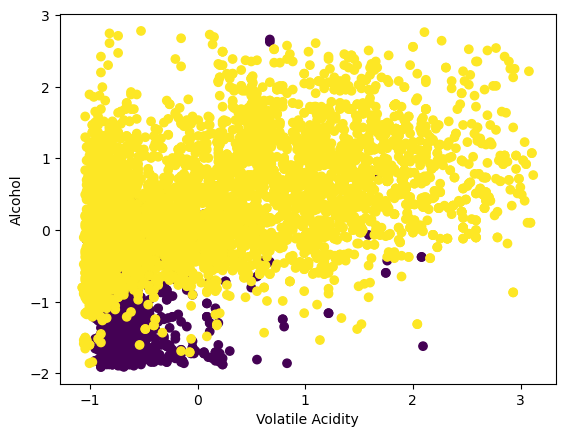

In [33]:
plt.scatter(X.iloc[:, 3], X.iloc[:,6], c=y)
plt.xlabel('Volatile Acidity')
plt.ylabel('Alcohol')

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.25, random_state = 40)

In [9]:
#Instantiate the model
model = Perceptron()
#Fit the model with data
model.fit(X_train, y_train, gamma=0.001, max_iter=1000)

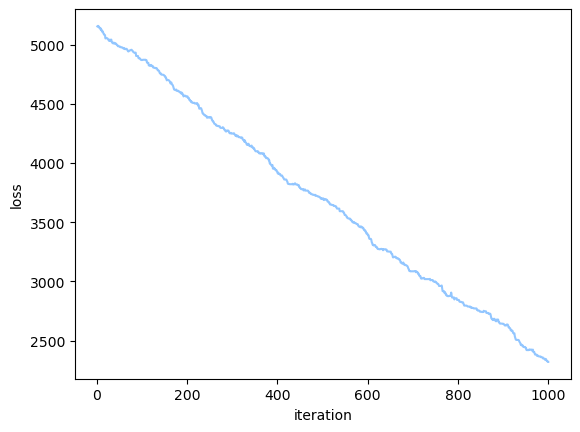

In [10]:
#Loss history during training
plt.plot(model.loss_history)
plt.xlabel('iteration')
plt.ylabel('loss')
plt.show()

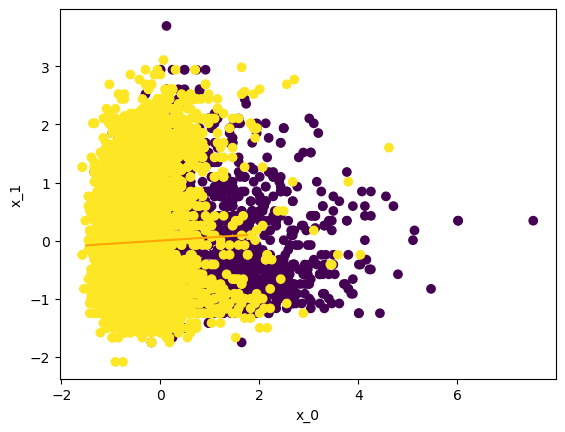

In [11]:
plt.scatter(X.iloc[:, 1], X.iloc[:,10], c=y, cmap='viridis')

domain = np.arange(-1.5, 2, 0.25)
w = model.weights
line = [-(w[1:2]*x)/w[0] for x in domain]

plt.plot(domain, line, label='separator', color = 'orange')
plt.xlabel('x_0')
plt.ylabel('x_1')
plt.show()

In [12]:
y_pred = model.prediction(X_train, model.weights)
print(f'Training accuracy score = {accuracy_score(y_train, y_pred)}')

y_pred_test = model.prediction(X_test, model.weights)
print(f'Test accuracy score = {accuracy_score(y_test, y_pred_test)}')

Training accuracy score = 0.5763546798029556
Test accuracy score = 0.5852307692307692
